
# Lab: TimeSeriesSplit — Multivariate Forecasting (1-step, Multi-step, Multi-output)
อัปเกรดจากไฟล์ก่อนหน้า: เพิ่ม **multi-step forecasting (H-step ahead)** ทั้งแบบ **direct**, **multi-output**, และ **recursive** พร้อมส่วน **โหลด dataset จริง** ได้ทันที


## 0) Setup

In [1]:

# --- core ---
import numpy as np
import pandas as pd

# --- modeling ---
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# --- metrics & viz ---
import matplotlib.pyplot as plt

# reproducibility
RNG = np.random.RandomState(42)

def mae_score(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def rmse_score(y_true, y_pred):
    """Root Mean Squared Error"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))



## 1) Synthetic multivariate time-series
เหมือนเดิม: จำลอง `y` + exogenous (`promo`, `temperature`, `macro_index`)


In [2]:

# --- generate ~2 years of daily data ---
N_DAYS = 730
dates = pd.date_range('2022-01-01', periods=N_DAYS, freq='D')

trend = 0.03 * np.arange(N_DAYS)
season_weekly = 5 * np.sin(2*np.pi*np.arange(N_DAYS)/7)
noise = RNG.normal(0, 2.0, size=N_DAYS)

promo = (RNG.rand(N_DAYS) < 0.12).astype(int)
temperature = 28 + 6*np.sin(2*np.pi*(np.arange(N_DAYS)-30)/365) + RNG.normal(0, 1.0, N_DAYS)
macro_index = np.cumsum(RNG.normal(0, 0.05, N_DAYS))

y = 20 + trend + season_weekly + 3*promo - 0.4*(temperature-28) + 0.8*macro_index + noise

df_syn = pd.DataFrame({
    'date': dates,
    'promo': promo,
    'temperature': temperature,
    'macro_index': macro_index,
    'y': y,
}).set_index('date')

df_syn.head()


,promo,temperature,macro_index,y
date,,,,
2022-01-01,1,25.119176,-0.150976,25.024977
2022-01-02,0,25.028707,-0.141783,24.737719
2022-01-03,1,26.137775,-0.051758,29.933501
2022-01-04,0,25.020349,0.010190,26.505490
2022-01-05,0,25.670739,0.020673,18.430517



## 2) (Optional) ใช้ **Dataset จริงของคุณ**
- เตรียม CSV ที่มีคอลัมน์ `date` (หรือกำหนดเอง) และ target `y` (ชื่ออื่นได้)
- ใส่ชื่อไฟล์และพารามิเตอร์ใน cell ด้านล่าง
- หากไม่มีไฟล์จริง จะ fallback ไปใช้ `df_syn`


In [3]:

# === CONFIG for REAL DATA ===
USE_REAL_DATA = False           # <-- เปลี่ยนเป็น True หากมีไฟล์จริง
CSV_PATH = "your_timeseries.csv"
DATE_COL = "date"
TARGET_COL = "y"
EXOG_COLS = None               # ตัวอย่าง: ['promo','temperature','macro_index']; ถ้า None จะใช้ทุกคอลัมน์ที่ไม่ใช่ target

def load_real_or_synthetic():
    if USE_REAL_DATA:
        df = pd.read_csv(CSV_PATH)
        if DATE_COL in df.columns:
            df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
            df = df.dropna(subset=[DATE_COL]).set_index(DATE_COL).sort_index()
        else:
            raise ValueError(f"DATE_COL '{DATE_COL}' not found in CSV.")
        if TARGET_COL not in df.columns:
            raise ValueError(f"TARGET_COL '{TARGET_COL}' not found in CSV.")
        if EXOG_COLS is None:
            # Use all columns except target as features (including any exogenous vars)
            ex_cols = [c for c in df.columns if c != TARGET_COL]
        else:
            ex_cols = EXOG_COLS
        df = df[[*ex_cols, TARGET_COL]].copy()
        df = df.dropna()
        return df, ex_cols, TARGET_COL
    else:
        # use synthetic
        df = df_syn.copy()
        ex_cols = ['promo','temperature','macro_index']
        return df, ex_cols, 'y'

df, EXOG, YCOL = load_real_or_synthetic()
df.head()


,promo,temperature,macro_index,y
date,,,,
2022-01-01,1,25.119176,-0.150976,25.024977
2022-01-02,0,25.028707,-0.141783,24.737719
2022-01-03,1,26.137775,-0.051758,29.933501
2022-01-04,0,25.020349,0.010190,26.505490
2022-01-05,0,25.670739,0.020673,18.430517



## 3) Feature engineering — Lags & Rolling
สร้าง lag/rolling จาก target พร้อมเก็บ exogenous เดิม


In [4]:

def make_lag_features(df, target_col='y', lags=(1,2,3,7), roll_windows=(3,7,14)):
    df = df.copy()
    for L in lags:
        df[f'{target_col}_lag{L}'] = df[target_col].shift(L)
    for W in roll_windows:
        df[f'{target_col}_rollmean{W}'] = df[target_col].shift(1).rolling(W).mean()
        df[f'{target_col}_rollstd{W}']  = df[target_col].shift(1).rolling(W).std()
    return df

feat_df = make_lag_features(df, YCOL)
feat_df = feat_df.dropna().copy()

X_1 = feat_df.drop(columns=[YCOL])
y_1 = feat_df[YCOL]
X_1.shape, y_1.shape


((716, 13), (716,))


## 4) TimeSeriesSplit Visualization (Expanding & Rolling)


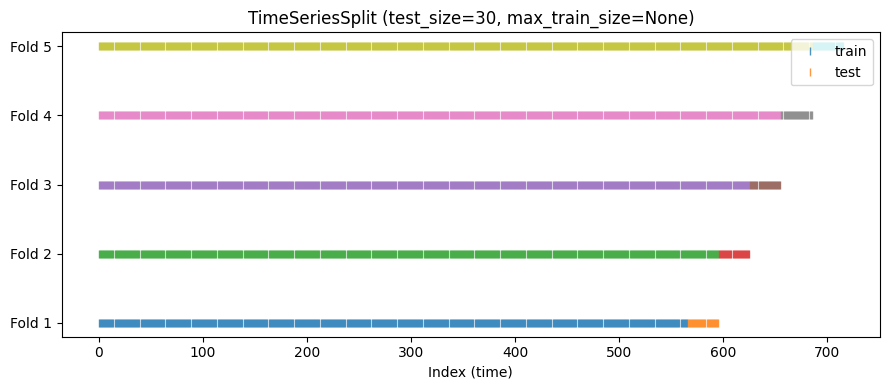

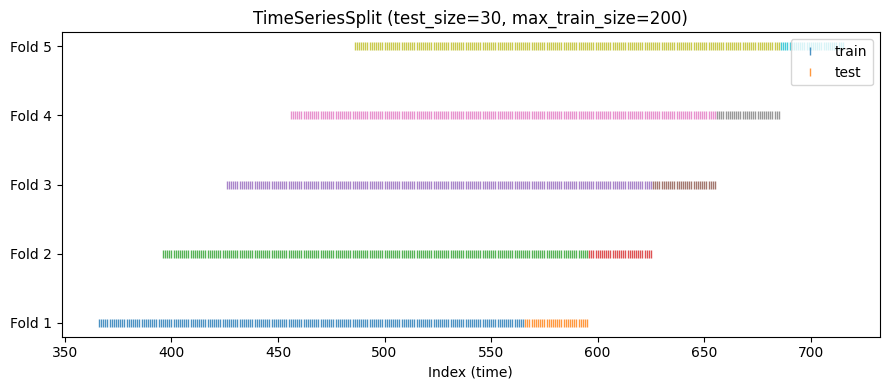

In [5]:

def show_tscv(n_splits=5, test_size=30, max_train_size=None):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=max_train_size)
    n = len(X_1)
    fig, ax = plt.subplots(figsize=(9, 2 + 0.4*n_splits))
    for i, (tr, te) in enumerate(tscv.split(np.arange(n)), 1):
        ax.plot(tr, [i]*len(tr), marker='|', linestyle='None', label='train' if i==1 else "", alpha=0.8)
        ax.plot(te, [i]*len(te), marker='|', linestyle='None', label='test' if i==1 else "", alpha=0.8)
    ax.set_yticks(range(1, n_splits+1))
    ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits+1)])
    ax.set_xlabel('Index (time)')
    ax.legend(loc='upper right')
    ax.set_title(f'TimeSeriesSplit (test_size={test_size}, max_train_size={max_train_size})')
    plt.tight_layout(); plt.show()

show_tscv(n_splits=5, test_size=30, max_train_size=None)   # expanding
show_tscv(n_splits=5, test_size=30, max_train_size=200)    # rolling



## 5) 1-step ahead baseline (Ridge, expanding)


In [6]:

tscv = TimeSeriesSplit(n_splits=5, test_size=30)

pipe_1 = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0, random_state=42))])

res_1 = []
for i, (tr, te) in enumerate(tscv.split(X_1), 1):
    Xtr, ytr = X_1.iloc[tr], y_1.iloc[tr]
    Xte, yte = X_1.iloc[te], y_1.iloc[te]
    pipe_1.fit(Xtr, ytr)
    yhat = pipe_1.predict(Xte)
    res_1.append({'fold': i, 'MAE': mae_score(yte,yhat), 'RMSE': rmse_score(yte,yhat)})

pd.DataFrame(res_1), np.mean([r['MAE'] for r in res_1]), np.mean([r['RMSE'] for r in res_1])


(   fold       MAE      RMSE
 0     1  2.150346  2.683645
 1     2  1.799857  2.485565
 2     3  2.250587  2.930637
 3     4  2.170466  2.676249
 4     5  2.026984  2.400980,
 np.float64(2.079647860153489),
 np.float64(2.6354148844455674))


## 6) Multi-step forecasting utilities
เราจะพยากรณ์ H วันล่วงหน้า (เช่น H=7) ด้วย 3 กลยุทธ์:
- **Direct**: เทรนโมเดลแยกสำหรับแต่ละ horizon
- **Multi-output**: เทรนทีเดียวพยากรณ์เป็นเวกเตอร์ (y[t+1]..y[t+H])
- **Recursive**: เทรน 1-step แล้วทบพยากรณ์ซ้ำ เติมเข้า lag


In [7]:

def build_supervised(df, target_col, exog_cols, lags=(1,2,3,7), roll_windows=(3,7,14), H=7):
    """Return X, Y where Y has H columns: y_{t+1}..y_{t+H}"""
    df_feat = make_lag_features(df, target_col=target_col, lags=lags, roll_windows=roll_windows)
    # future targets
    for h in range(1, H+1):
        df_feat[f'{target_col}_lead{h}'] = df_feat[target_col].shift(-h)
    df_feat = df_feat.dropna().copy()
    # features: exog + lags/rolls
    feature_cols = [c for c in df_feat.columns if c != target_col and not c.endswith(tuple([f'_lead{h}' for h in range(1, H+1)]))]
    # ensure exog columns present
    if exog_cols is not None:
        for c in exog_cols:
            if c not in feature_cols and c in df_feat.columns:
                feature_cols.append(c)
    X = df_feat[feature_cols].copy()
    Y = df_feat[[f'{target_col}_lead{h}' for h in range(1, H+1)]].copy()
    return X, Y

H = 7
X_H, Y_H = build_supervised(df, target_col=YCOL, exog_cols=EXOG, H=H)
X_H.shape, Y_H.shape, Y_H.columns.tolist()


((709, 13),
 (709, 7),
 ['y_lead1', 'y_lead2', 'y_lead3', 'y_lead4', 'y_lead5', 'y_lead6', 'y_lead7'])


### 6.1 Direct strategy (separate model per horizon)


In [8]:

def tscv_direct(base_estimator, X, Y, tscv):
    horizons = Y.shape[1]
    mae_per_h, rmse_per_h = [[] for _ in range(horizons)], [[] for _ in range(horizons)]
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        # train 1 model per horizon
        preds = np.zeros_like(Yte.values, dtype=float)
        for h in range(horizons):
            est = Pipeline([('scaler', StandardScaler()), ('model', base_estimator)])
            est.fit(Xtr, Ytr.iloc[:, h])
            preds[:, h] = est.predict(Xte)
        # metrics per horizon
        for h in range(horizons):
            mae_per_h[h].append(mae_score(Yte.iloc[:, h], preds[:, h]))
            rmse_per_h[h].append(rmse_score(Yte.iloc[:, h], preds[:, h]))
    mae_mean = [np.mean(m) for m in mae_per_h]
    rmse_mean = [np.mean(m) for m in rmse_per_h]
    return mae_mean, rmse_mean

tscv_H = TimeSeriesSplit(n_splits=5, test_size=30)
mae_dir, rmse_dir = tscv_direct(Ridge(random_state=42), X_H, Y_H, tscv_H)
pd.DataFrame({'horizon': np.arange(1, H+1), 'MAE': mae_dir, 'RMSE': rmse_dir})


,horizon,MAE,RMSE
0,1,2.021968,2.646458
1,2,2.040279,2.671016
2,3,2.230690,2.805607
3,4,2.306624,2.949420
4,5,2.120918,2.734381
5,6,2.034228,2.597061
6,7,2.329666,2.909639



### 6.2 Multi-output strategy (predict vector of future y at once)
ใช้ `MultiOutputRegressor` ครอบ Ridge/RF


In [9]:

def tscv_multioutput(base_estimator, X, Y, tscv):
    horizons = Y.shape[1]
    mae_per_h, rmse_per_h = [[] for _ in range(horizons)], [[] for _ in range(horizons)]
    model = Pipeline([('scaler', StandardScaler()), ('mo', MultiOutputRegressor(base_estimator))])
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        model.fit(Xtr, Ytr)
        preds = model.predict(Xte)  # shape (n, H)
        for h in range(horizons):
            mae_per_h[h].append(mae_score(Yte.iloc[:, h], preds[:, h]))
            rmse_per_h[h].append(rmse_score(Yte.iloc[:, h], preds[:, h]))
    mae_mean = [np.mean(m) for m in mae_per_h]
    rmse_mean = [np.mean(m) for m in rmse_per_h]
    return mae_mean, rmse_mean

mae_mo, rmse_mo = tscv_multioutput(Ridge(random_state=42), X_H, Y_H, tscv_H)
pd.DataFrame({'horizon': np.arange(1, H+1), 'MAE': mae_mo, 'RMSE': rmse_mo})


,horizon,MAE,RMSE
0,1,2.021968,2.646458
1,2,2.040279,2.671016
2,3,2.230690,2.805607
3,4,2.306624,2.949420
4,5,2.120918,2.734381
5,6,2.034228,2.597061
6,7,2.329666,2.909639



### 6.3 Recursive strategy (train 1-step, roll forward)
เทรน 1-step แล้วพยากรณ์ทีละก้าว โดยอัปเดต lag ด้วยค่าที่พยากรณ์


In [10]:

def recursive_forecast_1step(pipe, X_all, df_all, target_col, exog_cols, lags=(1,2,3,7), roll_windows=(3,7,14), start_idx=None, H=7):
    """Given a 1-step model, recursively predict H steps ahead starting from a given index window.

    X_all: features (with lags already computed) aligned with df_all after dropna

    start_idx: integer index (on X_all) to start predictions (i.e., first test index in a fold)

    Returns array of shape (n_test, H)
    """
    # We need original df to re-generate lags when rolling forward. We'll work on a copy.
    preds_matrix = []
    n_test = len(X_all) - start_idx
    # make a working series capturing past + future updates
    work_df = df_all.copy()
    # align dropna rows
    first_valid = (make_lag_features(work_df, target_col, lags, roll_windows).dropna()).index[0]
    work_df = work_df.loc[first_valid:].copy()
    y_series = work_df[target_col].copy()

    for t in range(n_test):
        # at absolute position start_idx + t in X_all, forecast H steps ahead
        # construct a temp df up to that time
        cutoff_time = X_all.index[start_idx + t]
        # ensure we only keep history up to cutoff_time
        hist = df_all.loc[:cutoff_time].copy()
        # now recursively roll forward H steps
        preds_h = []
        y_hist = hist[target_col].copy()
        for step in range(1, H+1):
            # rebuild features at this horizon using available y_hist as "latest past"
            tmp_df = hist.copy()
            tmp_df[target_col] = y_hist
            tmp_feat = make_lag_features(tmp_df, target_col, lags, roll_windows).dropna()
            x_last = tmp_feat.drop(columns=[target_col]).iloc[-1:]
            yhat_1 = pipe.predict(x_last)[0]
            preds_h.append(yhat_1)
            # append this prediction as next time step
            next_time = cutoff_time + pd.Timedelta(days=step)
            # if exog exists in future, we *assume* exog at next_time equals last observed (hold) — or you can plug known future exog here
            row_next = hist.iloc[[-1]].copy()
            row_next.index = [next_time]
            row_next[target_col] = yhat_1
            # keep exogenous as last known (can be replaced with real future exog if available)
            hist = pd.concat([hist, row_next])
            y_hist = hist[target_col]
        preds_matrix.append(preds_h)
    return np.array(preds_matrix)

def tscv_recursive(base_estimator, X1, y1, df_all, target_col, exog_cols, tscv, H=7):
    mae_h = [[] for _ in range(H)]
    rmse_h = [[] for _ in range(H)]
    pipe = Pipeline([('scaler', StandardScaler()), ('model', base_estimator)])
    for tr, te in tscv.split(X1):
        Xtr, Xte = X1.iloc[tr], X1.iloc[te]
        ytr, yte = y1.iloc[tr], y1.iloc[te]
        pipe.fit(Xtr, ytr)
        # build ground-truth matrix for comparison
        # we align indices to Y_H built on df_all
        XH, YH = build_supervised(df_all, target_col, exog_cols, H=H)  # rebuild to ensure alignment
        # find start index in XH corresponding to X1.index[te[0]]
        first_test_time = X1.index[te[0]]
        # find nearest index in XH
        start_idx = XH.index.get_indexer([first_test_time], method='nearest')[0]
        preds = recursive_forecast_1step(pipe, XH, df_all, target_col, exog_cols, H=H, start_idx=start_idx)
        # get the YH segment aligned to predictions length
        Yseg = YH.iloc[start_idx:start_idx+preds.shape[0]]
        for h in range(H):
            mae_h[h].append(mae_score(Yseg.iloc[:, h], preds[:, h]))
            rmse_h[h].append(rmse_score(Yseg.iloc[:, h], preds[:, h]))
    mae_mean = [np.mean(m) for m in mae_h]
    rmse_mean = [np.mean(m) for m in rmse_h]
    return mae_mean, rmse_mean

mae_rec, rmse_rec = tscv_recursive(Ridge(random_state=42), X_1, y_1, df, YCOL, EXOG, tscv_H, H=H)
pd.DataFrame({'horizon': np.arange(1, H+1), 'MAE': mae_rec, 'RMSE': rmse_rec})


,horizon,MAE,RMSE
0,1,2.943978,3.701463
1,2,3.057800,3.700340
2,3,3.268926,3.950264
3,4,3.382360,3.968641
4,5,3.423031,4.141976
5,6,3.477389,4.125576
6,7,3.515008,4.156790



## 7) เปรียบเทียบกลยุทธ์ Multi-step
แสดง MAE/RMSE ต่อ horizon (1..H)


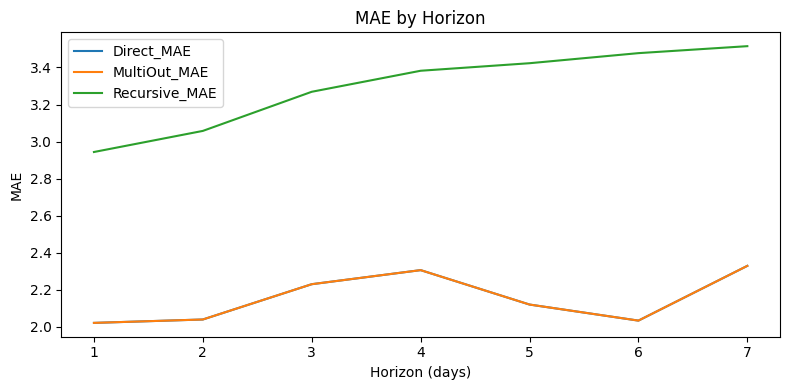

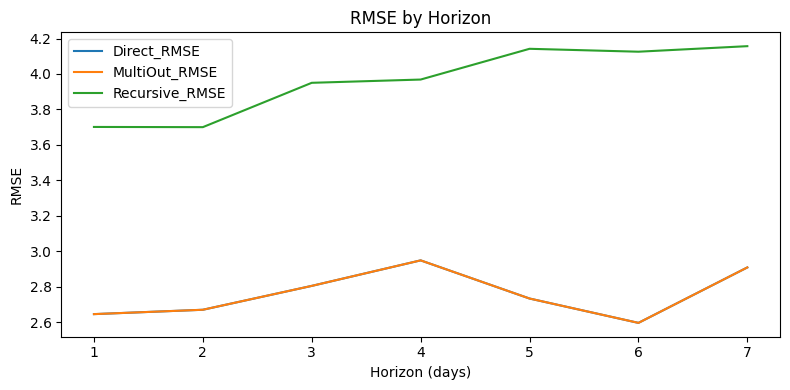

,Direct_MAE,Direct_RMSE,MultiOut_MAE,MultiOut_RMSE,Recursive_MAE,Recursive_RMSE
horizon,,,,,,
1,2.021968,2.646458,2.021968,2.646458,2.943978,3.701463
2,2.040279,2.671016,2.040279,2.671016,3.057800,3.700340
3,2.230690,2.805607,2.230690,2.805607,3.268926,3.950264
4,2.306624,2.949420,2.306624,2.949420,3.382360,3.968641
5,2.120918,2.734381,2.120918,2.734381,3.423031,4.141976
6,2.034228,2.597061,2.034228,2.597061,3.477389,4.125576
7,2.329666,2.909639,2.329666,2.909639,3.515008,4.156790


In [11]:

cmp = pd.DataFrame({
    'horizon': np.arange(1, H+1),
    'Direct_MAE': mae_dir, 'Direct_RMSE': rmse_dir,
    'MultiOut_MAE': mae_mo, 'MultiOut_RMSE': rmse_mo,
    'Recursive_MAE': mae_rec, 'Recursive_RMSE': rmse_rec
}).set_index('horizon')

ax = cmp[['Direct_MAE','MultiOut_MAE','Recursive_MAE']].plot(figsize=(8,4))
ax.set_title('MAE by Horizon'); ax.set_xlabel('Horizon (days)'); ax.set_ylabel('MAE')
plt.tight_layout(); plt.show()

ax = cmp[['Direct_RMSE','MultiOut_RMSE','Recursive_RMSE']].plot(figsize=(8,4))
ax.set_title('RMSE by Horizon'); ax.set_xlabel('Horizon (days)'); ax.set_ylabel('RMSE')
plt.tight_layout(); plt.show()

cmp



## 8) Multi-output with RandomForest + (Optional) GridSearch (inner TSCV)
**หมายเหตุ:** RF รองรับ multi-output โดยตรง (ไม่ต้อง MultiOutputRegressor) แต่เราจะใช้ `MultiOutputRegressor` ให้สอดคล้องกับ pipeline/score


In [12]:

outer = TimeSeriesSplit(n_splits=5, test_size=30)
inner = TimeSeriesSplit(n_splits=3, test_size=20)

mo_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mo', MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1)))
])

grid = {
    'mo__estimator__n_estimators': [200, 400],
    'mo__estimator__max_depth': [None, 10, 20],
    'mo__estimator__min_samples_split': [2, 5],
    'mo__estimator__min_samples_leaf': [1, 2],
    'mo__estimator__max_features': ['sqrt', 'log2', 1.0],
}

# Outer walk-forward evaluation with inner tuning (no leakage)
rf_mae_h, rf_rmse_h = [[] for _ in range(H)], [[] for _ in range(H)]
for tr, te in outer.split(X_H):
    Xtr, Xte = X_H.iloc[tr], X_H.iloc[te]
    Ytr, Yte = Y_H.iloc[tr], Y_H.iloc[te]
    gs = GridSearchCV(mo_pipe, grid, scoring='neg_root_mean_squared_error', cv=inner, n_jobs=-1)
    gs.fit(Xtr, Ytr)
    Yhat = gs.best_estimator_.predict(Xte)
    for h in range(H):
        rf_mae_h[h].append(mae_score(Yte.iloc[:, h], Yhat[:, h]))
        rf_rmse_h[h].append(rmse_score(Yte.iloc[:, h], Yhat[:, h]))

rf_mae = [np.mean(m) for m in rf_mae_h]
rf_rmse = [np.mean(m) for m in rf_rmse_h]
pd.DataFrame({'horizon': np.arange(1, H+1), 'MAE': rf_mae, 'RMSE': rf_rmse})


,horizon,MAE,RMSE
0,1,3.520621,4.230636
1,2,3.577050,4.308344
2,3,3.211406,3.902371
3,4,2.703606,3.292685
4,5,2.531101,3.148950
5,6,2.452635,3.014102
6,7,2.725360,3.299382



## 9) Visualization: last fold multi-step (Direct) vs Truth


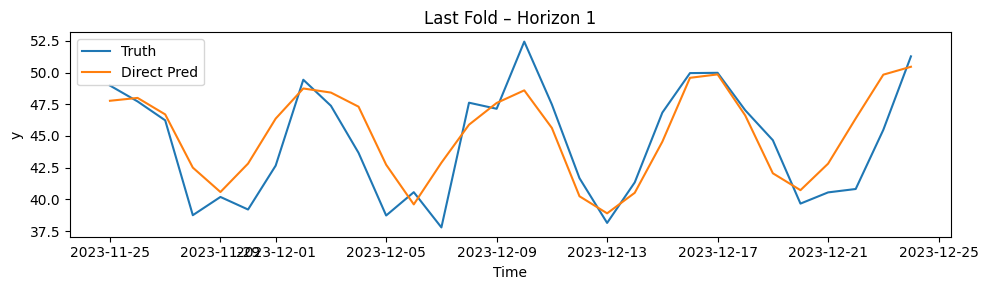

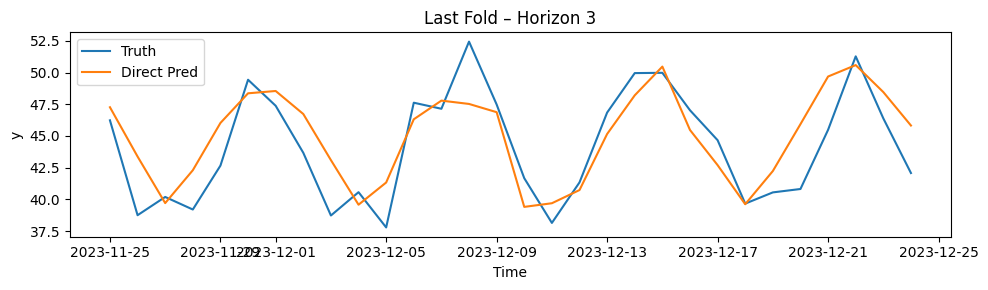

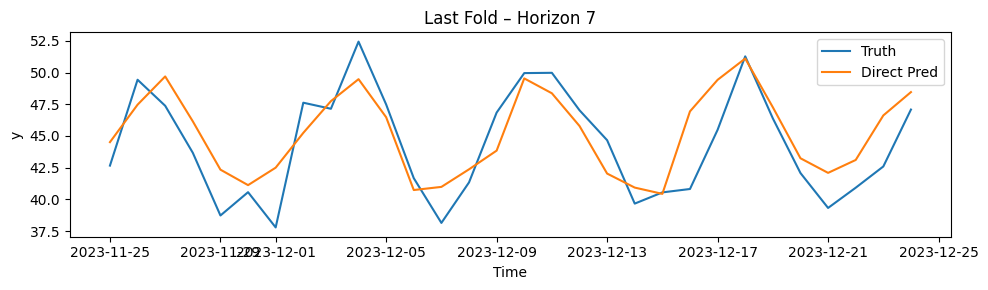

In [13]:

# For viz, recompute direct on last fold to get predictions over that segment
preds_direct = []
truth_direct = []
fold_idx = 0
for fold_idx, (tr, te) in enumerate(tscv_H.split(X_H), 1):
    pass

# get last fold indices
for i, (tr, te) in enumerate(tscv_H.split(X_H), 1):
    last_tr, last_te = tr, te
# train one model per horizon on last fold
pred_block = np.zeros((len(last_te), H))
for h in range(H):
    est = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=42))])
    est.fit(X_H.iloc[last_tr], Y_H.iloc[last_tr, h])
    pred_block[:, h] = est.predict(X_H.iloc[last_te])
preds_direct = pred_block
truth_direct = Y_H.iloc[last_te].values

# plot horizon 1, 3, 7
for h in [1,3,7]:
    plt.figure(figsize=(10,3))
    plt.plot(Y_H.index[last_te], truth_direct[:, h-1], label='Truth')
    plt.plot(Y_H.index[last_te], preds_direct[:, h-1], label='Direct Pred')
    plt.title(f'Last Fold – Horizon {h}')
    plt.xlabel('Time'); plt.ylabel('y')
    plt.legend(); plt.tight_layout(); plt.show()



## 10) Tips
- หากมี **exogenous ในอนาคต** (เช่น ปฏิทินโปรโมชันที่วางแผนไว้ล่วงหน้า), ให้นำค่าอนาคตมาใส่ในชุดทำนายเพื่อปรับปรุงคุณภาพ
- `Recursive` จะสะสม error ตาม horizon — ถ้า exog/สัญญาณไม่แรง อาจแพ้ `Direct/Multi-output`
- ทดลอง `gap=` ใน `TimeSeriesSplit` ถ้าต้องการกัน buffer ระหว่าง train/test
- ถ้า series หลายตัว (หลายร้าน/หลายสินค้า) และต้องพยากรณ์พร้อมกัน: ใช้ **panel data** + one-hot entity, หรือเทรนแยกโมเดลต่อ entity
